# Transformer Tutorial — From Scratch then PyTorch `nn.Transformer`

**Format:** formal tutorial, runnable.  
**What you'll learn (high-level):**

1. Implement **scaled dot-product self-attention** from scratch.  
2. Build **multi-head attention** and verify against `nn.MultiheadAttention`.  
3. Implement a **Transformer encoder block** with residuals, layer-norm, and feed-forward.  
4. Add **causal (masked) attention** and construct a simple Transformer decoder for autoregressive prediction.  
5. Compare a **self-defined Transformer** with PyTorch's **packed** `nn.Transformer` on identical inputs (numerical closeness checks).  
6. Train both models on a small dataset (Tiny Shakespeare) and compare loss/accuracy.

Each exercise is presented as code cells followed by verification checks students can run to confirm correctness. The notebook is self-contained and executable locally (it will download the dataset from the web at runtime).

**Notes for instructors / students:** run cells sequentially. If you want faster runs, reduce `d_model`, `num_heads`, sequence lengths, and training epochs in the training section.


In [1]:
# Setup: imports and helper utilities
import math
import os
import sys
from pathlib import Path
import time
import urllib.request

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# reproducibility
torch.manual_seed(0)

print('PyTorch version:', torch.__version__)
print('Device:', 'cuda' if torch.cuda.is_available() else 'cpu')


PyTorch version: 2.8.0+cu126
Device: cpu


## 1) Scaled Dot-Product Self-Attention (from scratch)

We will implement the core attention computation:

$\mathrm{Attention}(Q,K,V)=\mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V$

We'll provide a PyTorch `nn.Module` that:
- projects input `x` to queries, keys, values with `nn.Linear`
- computes attention scores, softmax, and returns output and attention weights

This is expected to operate on input shape `(batch, seq_len, d_model)` and return the same output shape.


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.query = nn.Linear(d_model, d_model)
        self.key   = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        # scale factor uses sqrt(d_k)
        self.scale = math.sqrt(d_model)

    def forward(self, x, mask=None):
        # x: [B, T, D]
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        # scores: [B, T, T]
        scores = torch.bmm(Q, K.transpose(1,2)) / self.scale
        if mask is not None:
            # mask expected to contain -inf for blocked positions (or very negative)
            scores = scores + mask
        weights = F.softmax(scores, dim=-1)
        out = torch.bmm(weights, V)
        return out, weights



### Verification
Check that attention weights sum to 1 across the last dimension.


In [ ]:

# Quick unit test
B, T, D = 2, 4, 8
x = torch.randn(B, T, D)
att = SelfAttention(D)
out, w = att(x)
print('out.shape =', out.shape)
print('weights.shape =', w.shape)
print('row sums (first example):', w[0].sum(dim=-1))


## 2) Multi-Head Attention

Multi-head attention runs several attention 'heads' in parallel, each with smaller `d_k = d_model/num_heads`, then concatenates the outputs and applies a final linear projection.

We'll implement `MultiHeadSelfAttention` and then compare its output with `torch.nn.MultiheadAttention` (after reshaping inputs appropriately).


In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, 'd_model must be divisible by num_heads'
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        # use single large linear and reshape trick for simplicity
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)
        self.scale = math.sqrt(self.d_k)

    def forward(self, x, mask=None):
        # x: [B, T, D]
        B, T, D = x.shape
        qkv = self.qkv(x)  # [B, T, 3D]
        qkv = qkv.view(B, T, 3, self.num_heads, self.d_k)  # [B, T, 3, H, d_k]
        q, k, v = qkv[:,:,0], qkv[:,:,1], qkv[:,:,2]  # each [B, T, H, d_k]
        # transpose to [B, H, T, d_k]
        q = q.permute(0,2,1,3)
        k = k.permute(0,2,1,3)
        v = v.permute(0,2,1,3)
        # compute scaled dot-product for each head
        # reshape for batched matmul: combine B and H
        q = q.contiguous().view(B*self.num_heads, T, self.d_k)
        k = k.contiguous().view(B*self.num_heads, T, self.d_k)
        v = v.contiguous().view(B*self.num_heads, T, self.d_k)
        scores = torch.bmm(q, k.transpose(1,2)) / self.scale  # [B*H, T, T]
        if mask is not None:
            # mask must be broadcastable to [B*H, T, T]
            scores = scores + mask
        weights = F.softmax(scores, dim=-1)
        out = torch.bmm(weights, v)  # [B*H, T, d_k]
        out = out.view(B, self.num_heads, T, self.d_k).permute(0,2,1,3).contiguous()
        out = out.view(B, T, D)
        out = self.out_proj(out)
        return out, weights.view(B, self.num_heads, T, T)

# Simple smoke test
B, T, D = 2, 5, 12
x = torch.randn(B, T, D)
mha = MultiHeadSelfAttention(D, num_heads=3)
out, w = mha(x)
print('out.shape', out.shape)
print('weights.shape', w.shape)


## 3) Transformer Encoder Block

An encoder block consists of:
- Multi-head self-attention + residual + layer-norm
- Position-wise feed-forward network (two linear layers with ReLU) + residual + layer-norm

We'll implement `TransformerEncoderLayerSimple` inspired by the original paper but in an educational, explicit form.


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class TransformerEncoderLayerSimple(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.mha = MultiHeadSelfAttention(d_model, num_heads)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention block
        attn_out, _ = self.mha(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.ln1(x)
        # Feed-forward block
        ff_out = self.ff(x)
        x = x + self.dropout(ff_out)
        x = self.ln2(x)
        return x

# smoke test
B, T, D = 2, 6, 12
enc = TransformerEncoderLayerSimple(D, num_heads=3, d_ff=48)
x = torch.randn(B, T, D)
out = enc(x)
print('out.shape', out.shape)


## 4) Positional Encoding & Small Transformer (Encoder or Decoder)

Transformers are position-agnostic; we add sinusoidal positional encodings (or learned embeddings). We'll implement sinusoidal positional encodings and a small model that stacks multiple encoder layers.

For each position $pos$ (e.g., 0, 1, 2, 3, …) and each dimension $i$ of the model’s hidden size $d_{model}$, we define the sinusoidal positional encoding as:

$\mathrm{PE}_{(pos,\,2i)} = \sin\!\left(\frac{pos}{10000^{2i/d_{\mathrm{model}}}}\right)$


$\mathrm{PE}_{(pos,\,2i+1)} = \cos\!\left(\frac{pos}{10000^{2i/d_{\mathrm{model}}}}\right)$



In [ ]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B, T, D]
        return x + self.pe[:, :x.size(1)]

class SimpleTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_heads=4, d_ff=512, num_layers=2, max_len=512):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = SinusoidalPositionalEncoding(d_model, max_len=max_len)
        self.layers = nn.ModuleList([
            TransformerEncoderLayerSimple(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])
        self.ln = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, vocab_size)

    def forward(self, idx, mask=None):
        # idx: [B, T] token indices
        x = self.tok_emb(idx)
        x = self.pos_enc(x)
        for layer in self.layers:
            x = layer(x, mask=mask)
        x = self.ln(x)
        logits = self.output_proj(x)
        return logits

# smoke test with tiny vocab
vocab_size = 50
model = SimpleTransformerEncoder(vocab_size, d_model=64, num_heads=4, d_ff=128, num_layers=2)
B, T = 2, 10
idx = torch.randint(0, vocab_size, (B, T))
logits = model(idx)
print('logits.shape', logits.shape)  # [B, T, vocab_size]


## 5) Tiny Shakespeare dataset & training utilities

We'll use Karpathy's Tiny Shakespeare (~1 MB) for a character-level language modeling task (next-character prediction). The notebook will download the raw text at runtime. If running offline, place the file at `data/tiny_shakespeare.txt`.

We'll create a small `Dataset` to produce fixed-length sequences and targets for next-token prediction.


In [ ]:
# Download dataset (if not present)
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
local_path = data_dir / 'tiny_shakespeare.txt'
if not local_path.exists():
    print('Downloading Tiny Shakespeare...')
    urllib.request.urlretrieve(url, local_path)
else:
    print('Dataset already exists at', local_path)

text = local_path.read_text()
print('dataset length (chars):', len(text))

# build vocab
chars = sorted(list(set(text)))
vocab_size = len(chars)
print('vocab size:', vocab_size)
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}

# dataset
class CharDataset(Dataset):
    def __init__(self, data, seq_len=100):
        self.seq_len = seq_len
        self.data = data
        self.ids = [stoi[c] for c in data]
    def __len__(self):
        return 5000
    def __getitem__(self, idx):
        x = torch.tensor(self.ids[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.ids[idx+1:idx+self.seq_len+1], dtype=torch.long)
        return x, y

# quick smoke
ds = CharDataset(text, seq_len=64)
print('dataset len', len(ds))
print('example shapes', ds[0][0].shape, ds[0][1].shape)


## 6) Training both models and comparing performance

We'll:
- Instantiate **our** `SimpleTransformerEncoder` and a **packed** `nn.Transformer` style model (using `nn.TransformerEncoder`).
- Train for a small number of steps/epochs to demonstrate training behavior.

**Warning:** full training can be slow. The provided defaults are small so the notebook runs in reasonable time on CPU. Increase model sizes only if you have GPU and time.


In [ ]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
# -----------------------------
# Training & evaluation utilities
# -----------------------------
def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    for xb, yb in tqdm(dataloader):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)  # [B, T, V]
        B, T, V = logits.shape
        loss = criterion(logits.view(B*T, V), yb.view(B*T))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for xb, yb in tqdm(dataloader):
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            B, T, V = logits.shape
            loss = criterion(logits.view(B*T, V), yb.view(B*T))
            total_loss += loss.item()
    return total_loss / len(dataloader)


# -----------------------------
# Setup device, data, model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = 64
batch_size = 16

# Dataloaders
full_dataset = CharDataset(text, seq_len=seq_len)
train_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(full_dataset, batch_size=batch_size)

# Our custom Transformer
model = SimpleTransformerEncoder(
    vocab_size=vocab_size,
    d_model=64,
    num_heads=4,
    d_ff=256,
    num_layers=2,
    max_len=512
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


# -----------------------------
# Training loop with loss recording
# -----------------------------
epochs = 5
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    t0 = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = evaluate(model, val_loader, device)
    t1 = time.time()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch} | time {t1-t0:.1f}s | "
        f"train loss {train_loss:.4f} | val loss {val_loss:.4f}"
    )

print("Training finished.")



In [ ]:
# -----------------------------
# Plot losses
# -----------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 7) Decoder and Masking

This section fills in the missing **decoder** and **masking** pieces for our mini-Transformer tutorial.

**Goals**
- Understand *why* we need **masked self‑attention** (a.k.a. look‑ahead/causal mask) in the decoder.
- Build a clean **`DecoderLayer`** with both self‑attention and cross‑attention.
- Implement practical **mask utilities**: subsequent mask (causal) and padding masks.
- Verify masks via a small **visualization demo**.
- Practice with short **exercises** (and reference answers).

## 7.1 Why masking in the decoder?

During sequence generation, the decoder predicts token *t* using only tokens **≤ t**. To enforce this, we apply a **look‑ahead (causal) mask** so position *t* cannot attend to positions *> t*.  
We also apply **padding masks** to ignore `<pad>` tokens when sequences have different lengths.

Let $Q,K,V \in \mathbb{R}^{T \times d}$. Scaled dot‑product attention is
$\mathrm{softmax}((QK^\top)/\sqrt{d_k} + M)V,$
where $M_{ij}=-\infty$ if position $i$ is **not allowed** to see $j$ (future tokens or pads), and 0 otherwise.

## 7.2 Mask utilities

We implement:
- **`generate_square_subsequent_mask(L)`** → a boolean matrix shaped `[L, L]` that masks *future* tokens (upper triangular).
- **`make_padding_mask(tokens, pad_idx=0)`** → a boolean matrix shaped `[B, L]` that masks pad positions per batch.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def generate_square_subsequent_mask(L: int, device=None):
    """
    Causal (look-ahead) mask for decoder self-attention.
    Returns a [L, L] boolean tensor where True means "mask out".
    """
    m = torch.triu(torch.ones((L, L), device=device, dtype=torch.bool), diagonal=1)
    return m  # True above the diagonal -> disallow attending to future

def make_padding_mask(tokens: torch.Tensor, pad_idx: int = 0):
    """
    tokens: LongTensor [B, L]
    Returns: BoolTensor [B, L], True for pad positions.
    """
    return tokens.eq(pad_idx)

## 7.3 A minimal `DecoderLayer`

This layer stacks:
1) **Masked self‑attention** over the target sequence  
2) **Cross‑attention** that queries the encoder output ("memory")  
3) A position‑wise feed‑forward network  

Each sublayer has residual + layer norm.

In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = F.gelu

    def forward(
        self,
        tgt,                       # [B, Lt, d]
        memory,                    # [B, Ls, d] encoder outputs
        tgt_mask=None,             # [Lt, Lt]   (causal)
        tgt_key_padding_mask=None, # [B, Lt]
        memory_key_padding_mask=None # [B, Ls]
    ):
        # 1) masked self-attention
        x = tgt
        _sa_out, _ = self.self_attn(
            x, x, x,
            attn_mask=tgt_mask,
            key_padding_mask=tgt_key_padding_mask,
            need_weights=False
        )
        x = x + self.dropout1(_sa_out)
        x = self.norm1(x)

        # 2) cross-attention
        _ca_out, _ = self.cross_attn(
            x, memory, memory,
            key_padding_mask=memory_key_padding_mask,
            need_weights=False
        )
        x = x + self.dropout2(_ca_out)
        x = self.norm2(x)

        # 3) feed-forward
        _ff = self.linear2(self.dropout(self.activation(self.linear1(x))))
        x = x + self.dropout3(_ff)
        x = self.norm3(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, d_model: int, nhead: int, num_layers: int, dim_feedforward: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, nhead, dim_feedforward, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        x = tgt
        for layer in self.layers:
            x = layer(
                x, memory,
                tgt_mask=tgt_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask
            )
        return self.norm(x)

## 7.4 Demo: Visualize the causal mask

We show the boolean **subsequent mask** and verify attention cannot see future tokens.

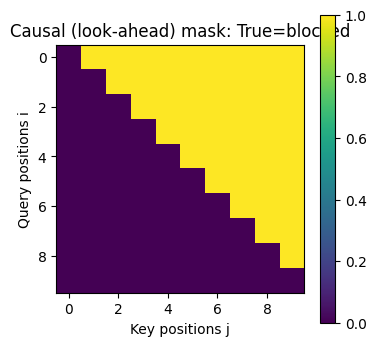

In [9]:
import matplotlib.pyplot as plt

L = 10
mask = generate_square_subsequent_mask(L)
plt.figure(figsize=(4,4))
plt.imshow(mask.cpu().numpy(), interpolation='nearest')
plt.title("Causal (look-ahead) mask: True=blocked")
plt.xlabel("Key positions j")
plt.ylabel("Query positions i")
plt.colorbar()
plt.show()

### Exercise 1 (masking)

Implement a function `apply_causal_mask(scores)` that sets the *upper triangle* of the `[L, L]` attention score matrix to `-inf` so softmax will zero it out.

**Hint:** use `torch.triu` with `diagonal=1`.

*(Write your solution in the next cell. An answer is provided after it.)*

In [11]:
# TODO: Your implementation here
import torch

def apply_causal_mask(scores: torch.Tensor):
    """
    scores: [L, L] float tensor (single head for simplicity)
    Return: masked scores
    """
    L = scores.size(-1)
    # --- your code ---
    raise NotImplementedError("Fill the causal mask here")

**Answer (Exercise 1):**

In [12]:
def apply_causal_mask(scores: torch.Tensor):
    L = scores.size(-1)
    mask = torch.triu(torch.ones(L, L, dtype=torch.bool, device=scores.device), diagonal=1)
    scores = scores.masked_fill(mask, float("-inf"))
    return scores

# quick test
torch.manual_seed(0)
S = torch.randn(5,5)
Sm = apply_causal_mask(S.clone())
print("Upper triangle is -inf:", torch.isinf(Sm).sum().item() == (5*4)//2)

Upper triangle is -inf: True


### Exercise 2 (decoder step)

Given `tgt` (decoder inputs) and `memory` (encoder outputs), run one **`DecoderLayer`** with a correct **`tgt_mask`** from `generate_square_subsequent_mask`.

*(Write your solution in the next cell. An answer is provided after it.)*

In [13]:
# TODO: Your implementation here
B, Lt, Ls, d_model, nhead = 2, 7, 9, 32, 4
torch.manual_seed(0)
tgt = torch.randn(B, Lt, d_model)
memory = torch.randn(B, Ls, d_model)

layer = DecoderLayer(d_model, nhead, dim_feedforward=64, dropout=0.0)

# --- your code ---
# x = layer(...)
# print(x.shape)  # expect [B, Lt, d_model]

**Answer (Exercise 2):**

In [14]:
B, Lt, Ls, d_model, nhead = 2, 7, 9, 32, 4
torch.manual_seed(0)
tgt = torch.randn(B, Lt, d_model)
memory = torch.randn(B, Ls, d_model)

layer = DecoderLayer(d_model, nhead, dim_feedforward=64, dropout=0.0)
tgt_mask = generate_square_subsequent_mask(Lt)

x = layer(tgt, memory, tgt_mask=tgt_mask)
print(x.shape)

torch.Size([2, 7, 32])


## 7.6 How to plug into your existing encoder

If you already built an **`Encoder`** in previous sections, you can integrate as follows:

```python
# Encode source tokens
src_emb = src_embed(src_tokens) + pos_embed_src  # [B, Ls, d]
memory = encoder(src_emb, src_key_padding_mask=src_pad_mask)

# Prepare decoder inputs (shifted right with <bos>), add positions
tgt_inp = tgt_embed(tgt_tokens_in) + pos_embed_tgt  # [B, Lt, d]

# Masks
tgt_mask = generate_square_subsequent_mask(Lt)
tgt_pad_mask = make_padding_mask(tgt_tokens_in, pad_idx=PAD)

# Decode
dec_out = decoder(tgt_inp, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_pad_mask,
                  memory_key_padding_mask=src_pad_mask)
logits = final_proj(dec_out)  # [B, Lt, vocab]
```
> **Tip:** For auto‑regressive *inference*, you typically loop token‑by‑token and only pass the prefix to the decoder, re‑using cached keys/values for speed.

# 8) defining transformers in real-world situations

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=8, num_encoder_layers=3,
                 num_decoder_layers=3, dim_feedforward=512, max_len=100, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True  # (B, L, D)
        )
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt):
        B, Ls = src.shape
        _, Lt = tgt.shape
        device = src.device

        # Positional indices
        src_pos = torch.arange(Ls, device=device).unsqueeze(0).expand(B, Ls)
        tgt_pos = torch.arange(Lt, device=device).unsqueeze(0).expand(B, Lt)

        # Embedding + Position
        src_emb = self.embedding(src) + self.pos_embedding(src_pos)
        tgt_emb = self.embedding(tgt) + self.pos_embedding(tgt_pos)

        # Mask for auto-regressive decoding
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(Lt).to(device)

        out = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask)
        logits = self.fc_out(out)
        return logits
